In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from copy import deepcopy

In [2]:
file_path = "ks-projects-201801.csv"
df = pd.read_csv(file_path)
display(df)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


ID、name、currencyは常識的にstateと関係あると思えないのであらかじめ取り除いた

In [33]:
variables = ["category", "main_category", "deadline", "launched", "state", "backers", "country", "usd pledged", "usd_pledged_real", "usd_goal_real"]
df_processed = deepcopy(df[variables])

In [34]:
display(df_processed["state"].unique())

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [35]:
display(df_processed.isnull().sum())
df_processed = df_processed.dropna()

category               0
main_category          0
deadline               0
launched               0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [36]:
df_processed["deadline"] = pd.to_datetime(df_processed["deadline"])
df_processed["launched"] = pd.to_datetime(df_processed["launched"])
df_processed["duration"] = (df_processed["deadline"] - df_processed["launched"]).dt.days
df_processed["launched"] = df_processed["launched"].dt.year

In [37]:
df_processed["category"] = df_processed["category"].astype("category")
df_processed["main_category"] = df_processed["main_category"].astype("category")
df_processed["country"] = df_processed["country"].astype("category")
df_processed["state"] = df_processed["state"].astype("category")
df_processed["category"] = LabelEncoder().fit_transform(df_processed["category"])
df_processed["main_category"] = LabelEncoder().fit_transform(df_processed["main_category"])
df_processed["country"] = LabelEncoder().fit_transform(df_processed["country"])
state_encoder = LabelEncoder()
df_processed["state"] = state_encoder.fit_transform(df_processed["state"])
list(state_encoder.inverse_transform([0, 1, 2, 3, 4])) #state変数のラベルの意味を順に出力

['canceled', 'failed', 'live', 'successful', 'suspended']

In [9]:
df_processed["usd_pledged_diff"] = df_processed["usd_pledged_real"] - df_processed["usd pledged"]

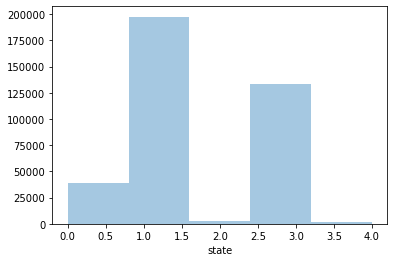

In [41]:
sns.distplot(df_processed["state"], bins = 5, kde = False)
plt.show()

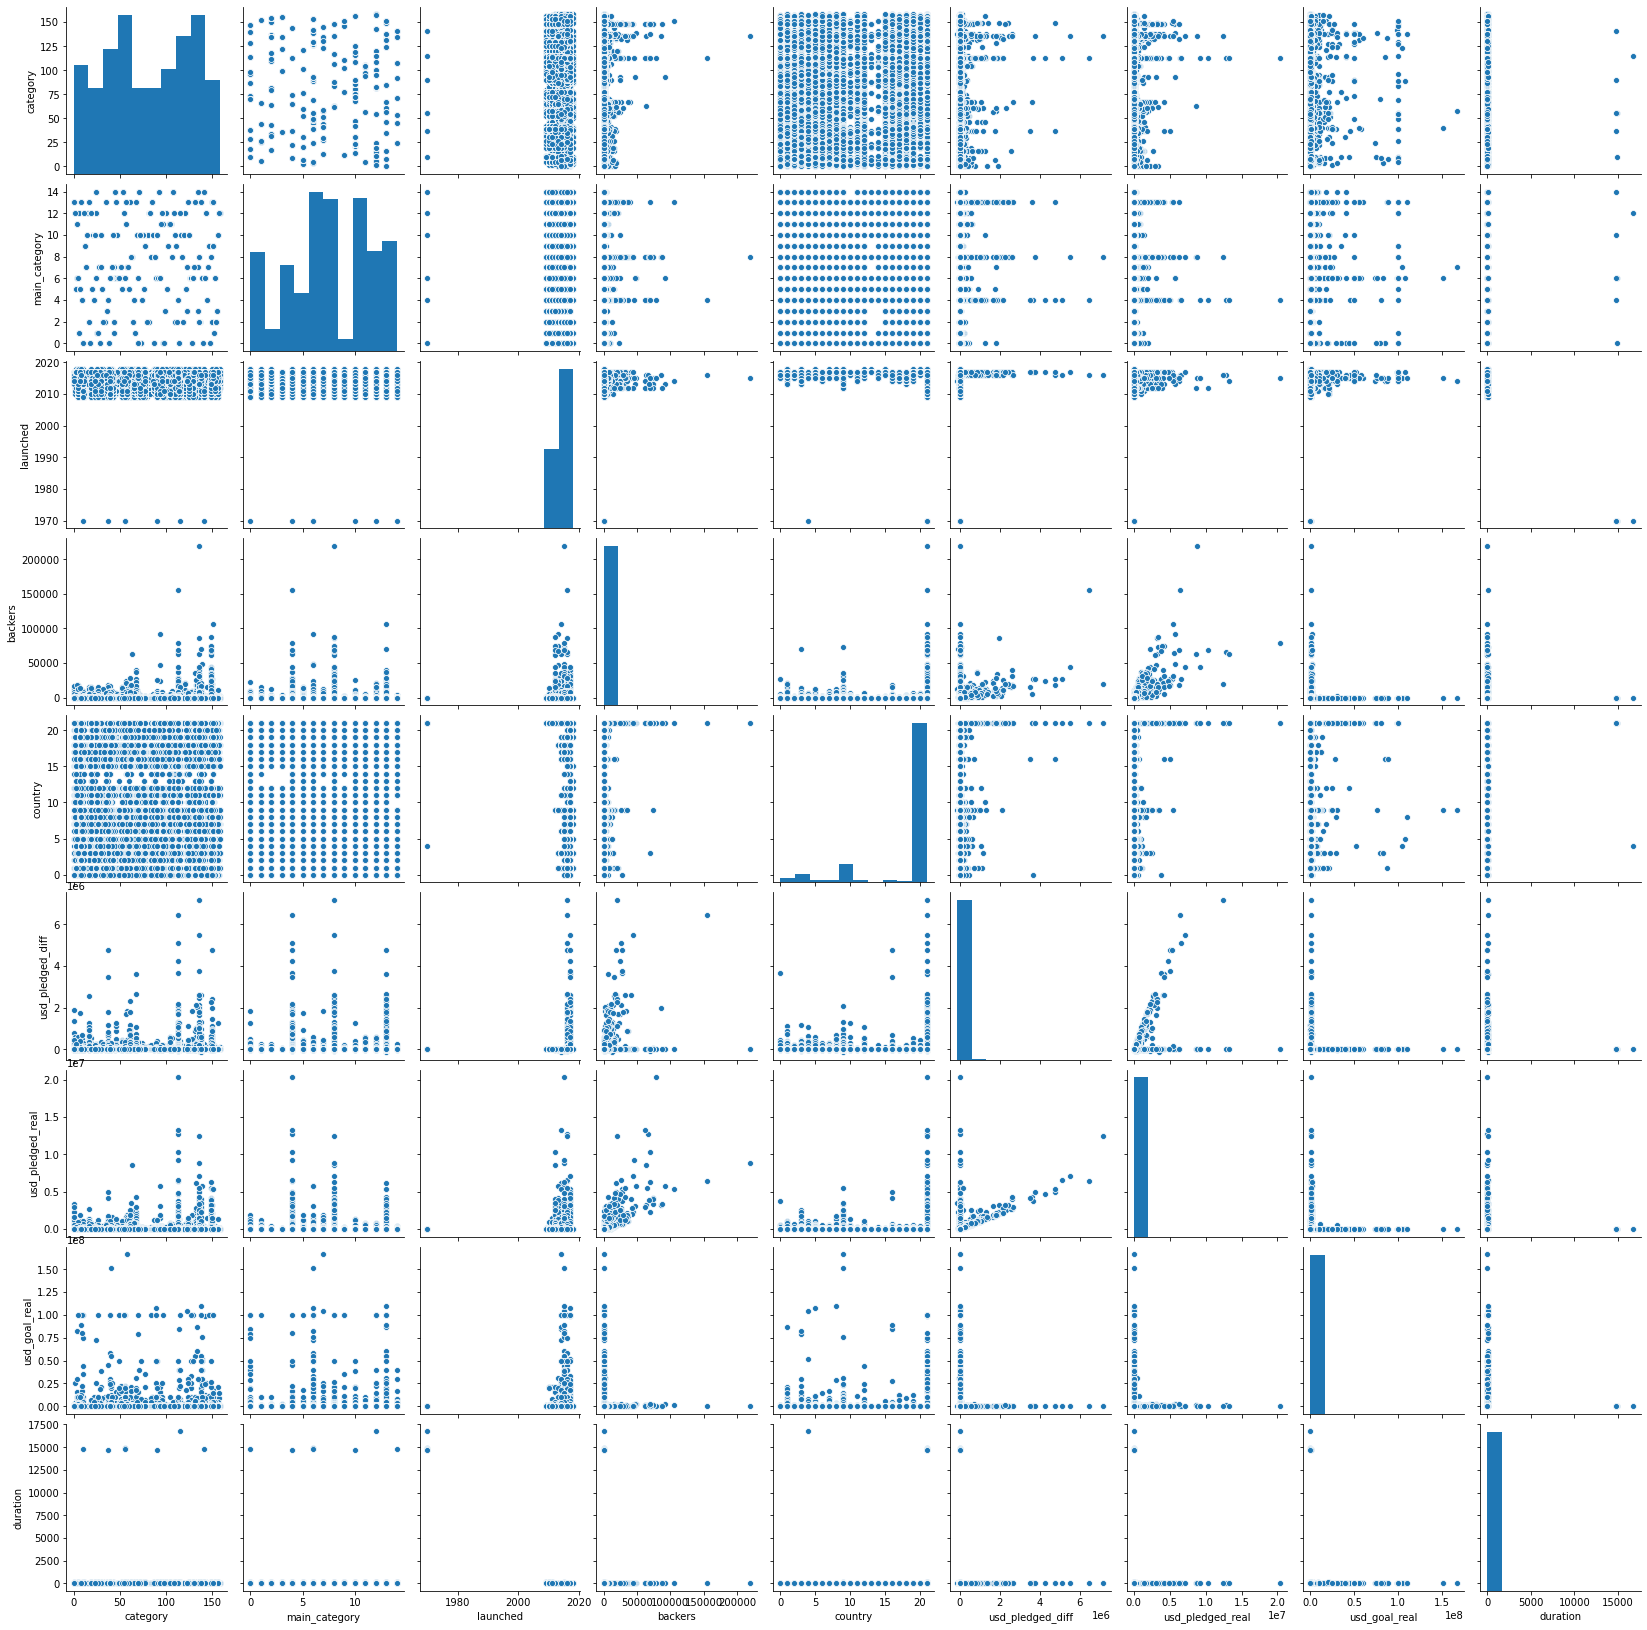

In [10]:
sns.pairplot(df_processed[["category", "main_category", "launched", "state", "backers", "country", "usd_pledged_diff", "usd_pledged_real", "usd_goal_real", "duration"]])
plt.show()

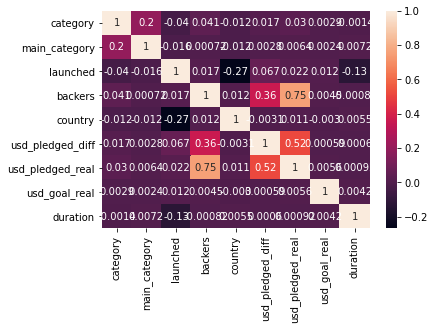

In [11]:
sns.heatmap(df_processed[["category", "main_category", "launched", "state", "backers", "country", "usd_pledged_diff", "usd_pledged_real", "usd_goal_real", "duration"]].corr(), annot = True)
plt.show()

backersとusd_pledged_realに強い相関関係が見られるので、backersの方を説明変数から取り除いた

In [12]:
explanatory_variables = ["category", "main_category", "launched", "country", "usd_pledged_diff", "usd_pledged_real", "usd_goal_real", "duration"]
target_variable = "state"
x = deepcopy(df_processed[explanatory_variables])
y = deepcopy(df_processed[target_variable])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
display(x_train)
display(y_train)

,category,main_category,launched,country,usd_pledged_diff,usd_pledged_real,usd_goal_real,duration
302640,25,1,2017,21,23157.0,34418.00,5500.00,29
247145,157,12,2015,1,0.0,0.00,1405.48,30
165819,8,13,2015,21,0.0,5.00,500.00,29
136993,90,10,2016,21,0.0,0.00,350.00,29
230557,109,10,2015,5,0.0,0.00,38794.06,29
...,...,...,...,...,...,...,...,...
363430,141,14,2013,21,0.0,8535.12,8000.00,27
361713,29,7,2014,3,0.0,0.92,4596.43,29
153845,3,6,2016,21,10.0,10.00,1500.00,29
119129,95,12,2017,21,6621.0,10938.00,10000.00,35


302640    successful
247145        failed
165819        failed
136993      canceled
230557        failed
             ...    
363430    successful
361713      canceled
153845        failed
119129    successful
308810    successful
Name: state, Length: 299891, dtype: category
Categories (5, object): ['canceled', 'failed', 'live', 'successful', 'suspended']

In [13]:
steps = [
    ('rf', RandomForestClassifier(n_estimators = 100, random_state = 0))
]
pipeline = Pipeline(steps = steps)

In [14]:
parameters = {
    "rf__max_depth":[i for i in range(17, 20)]
}

In [15]:
grid = GridSearchCV(pipeline, param_grid = parameters, cv = 4, n_jobs = 6)
grid.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=6, param_grid={'rf__max_depth': [17, 18, 19]})

Accuracy : 0.8816907420004535
Precision : 0.4096590330019005
Recall : 0.8622049587868265


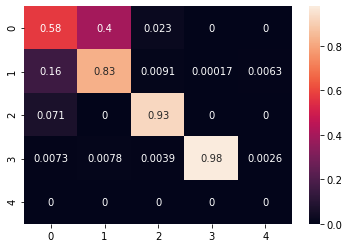

In [16]:
y_pred = grid.predict(x_test)
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, average = 'macro', zero_division = 1)
recall = recall_score(y_pred, y_test, average = 'macro', zero_division = 1)
print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
cm = confusion_matrix(y_pred, y_test, normalize = "true")
sns.heatmap(cm, annot = True)
plt.show()

In [17]:
print(grid.best_estimator_)

Pipeline(steps=[('rf', RandomForestClassifier(max_depth=17, random_state=0))])
